In [2]:
import json
import pandas as pd

In [3]:
# Function to load JSON data into a DataFrame
def load_json_to_df(json_file):
    with open(json_file, 'r') as file:
        data = json.load(file)
    return pd.DataFrame.from_dict(data, orient='index')

# List of JSON files
json_files = ['HR_filtered.json', 'HF_filtered.json', 'MR_filtered.json', 'MF_filtered.json']
dfs = []

# Load each JSON file into a DataFrame and store them in a list
for json_file in json_files:
    df = load_json_to_df('data/' + json_file)
    dfs.append(df)

# Naming the DataFrames
HR_df, HF_df, MR_df, MF_df = dfs

In [21]:
HR = HR_df['filtered']
HF = HF_df['filtered']
MR = MR_df['filtered']
MF = MF_df['filtered']

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

In [10]:
# Concatenate all data into one DataFrame
df = pd.concat([HR, HF, MR, MF], ignore_index=True)

# Assigning labels: 0 for human news, 1 for AI news
labels = [0]*len(HR) + [0]*len(HF) + [1]*len(MR) + [1]*len(MF)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size=0.2, random_state=42)

In [12]:
# Creating TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Logistic Regression Human vs AI Prediction

In [13]:
# Logistic Regression model
logistic_regression_model = LogisticRegression(max_iter=1000)
logistic_regression_model.fit(X_train_tfidf, y_train)
logistic_regression_predictions = logistic_regression_model.predict(X_test_tfidf)

Logistic Regression Accuracy: 0.9802910855063675
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1651
           1       0.99      0.97      0.98      1647

    accuracy                           0.98      3298
   macro avg       0.98      0.98      0.98      3298
weighted avg       0.98      0.98      0.98      3298



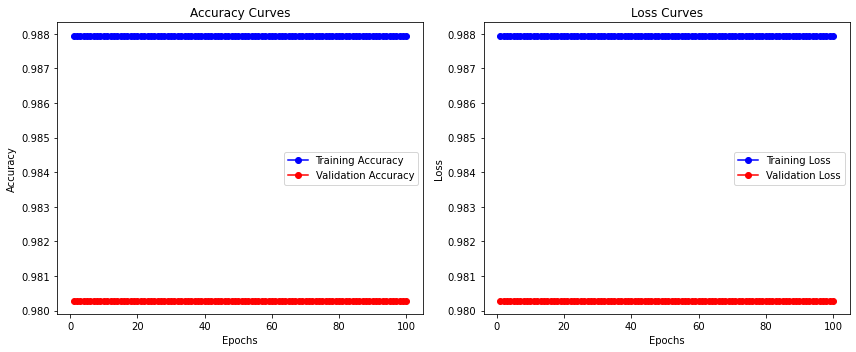

In [22]:
# Lists to store accuracy and loss values
train_accuracy = []
val_accuracy = []
train_loss = []
val_loss = []

# Train the model and store accuracy and loss values
for epoch in range(100):
    logistic_regression_model.fit(X_train_tfidf, y_train)
    
    # Calculate training accuracy and loss
    train_preds = logistic_regression_model.predict(X_train_tfidf)
    train_accuracy.append(accuracy_score(y_train, train_preds))
    train_loss.append(logistic_regression_model.fit(X_train_tfidf, y_train).score(X_train_tfidf, y_train))
    
    # Calculate validation accuracy and loss
    val_preds = logistic_regression_model.predict(X_test_tfidf)
    val_accuracy.append(accuracy_score(y_test, val_preds))
    val_loss.append(logistic_regression_model.score(X_test_tfidf, y_test))

# Evaluate Logistic Regression model
print("Logistic Regression Accuracy:", accuracy_score(y_test, logistic_regression_model.predict(X_test_tfidf)))
print("Logistic Regression Classification Report:")
print(classification_report(y_test, logistic_regression_model.predict(X_test_tfidf)))

# Plot accuracy and loss curves
epochs = range(1, len(train_accuracy) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Create the TF-IDF vectorizer and transform the data
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Define the parameter grid for GridSearchCV
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 500, 1000]
}

# Create a logistic regression model
logistic_regression_model = LogisticRegression()

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=logistic_regression_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_tfidf, y_train)

# Print the best parameters and the corresponding score
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy Score:", grid_search.best_score_)

# Evaluate the model with the best parameters on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_tfidf)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test Classification Report:")
print(classification_report(y_test, y_pred))

# Alternatively, you can use RandomizedSearchCV for a faster search
# Define the parameter distributions for RandomizedSearchCV
param_distributions = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 500, 1000]
}

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=logistic_regression_model, param_distributions=param_distributions, cv=5, scoring='accuracy', n_jobs=-1, n_iter=20)
random_search.fit(X_train_tfidf, y_train)

# Print the best parameters and the corresponding score
print("Best Parameters:", random_search.best_params_)
print("Best Accuracy Score:", random_search.best_score_)

# Evaluate the model with the best parameters on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_tfidf)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test Classification Report:")
print(classification_report(y_test, y_pred))


Best Parameters: {'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best Accuracy Score: 0.9829440931085334
Test Accuracy: 0.9805942995755003
Test Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1651
           1       0.99      0.97      0.98      1647

    accuracy                           0.98      3298
   macro avg       0.98      0.98      0.98      3298
weighted avg       0.98      0.98      0.98      3298

Best Parameters: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 500, 'C': 10}
Best Accuracy Score: 0.9829440931085334
Test Accuracy: 0.9805942995755003
Test Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1651
           1       0.99      0.97      0.98      1647

    accuracy                           0.98      3298
   macro avg       0.98      0.98      0.98      3298
weighted avg       0.98      

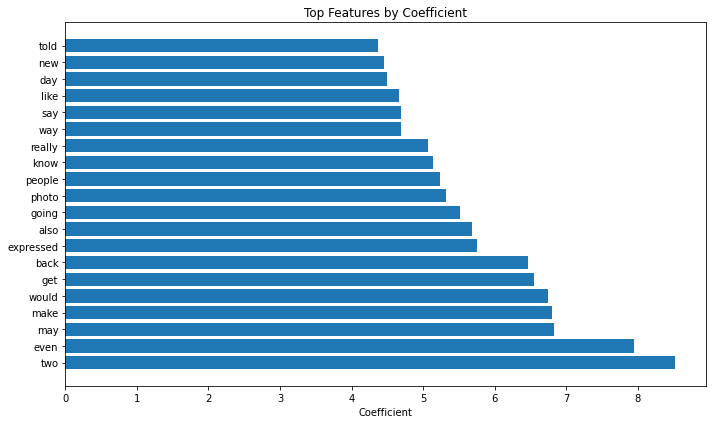

Top 20 features with the highest coefficients:
two: 8.5217
even: 7.9425
may: 6.8259
make: 6.7962
would: 6.7444
get: 6.5506
back: 6.4700
expressed: 5.7535
also: 5.6773
going: 5.5186
photo: 5.3177
people: 5.2292
know: 5.1336
really: 5.0705
way: 4.6960
say: 4.6874
like: 4.6600
day: 4.4970
new: 4.4581
told: 4.3715


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

# Create the TF-IDF vectorizer and transform the data
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
feature_names = np.array(tfidf_vectorizer.get_feature_names())

# Train the logistic regression model
logistic_regression_model = LogisticRegression(max_iter=1000)
logistic_regression_model.fit(X_train_tfidf, y_train)

# Get the coefficients of the trained model
coef = logistic_regression_model.coef_[0]

# Sort the coefficients and feature names
sorted_coef_indices = np.argsort(np.abs(coef))[::-1]
sorted_coef = coef[sorted_coef_indices]
sorted_feature_names = feature_names[sorted_coef_indices]

# Plot the top 20 features with the highest coefficients
plt.figure(figsize=(10, 6))
top_n = 20
top_features = sorted_feature_names[:top_n]
top_coef = sorted_coef[:top_n]
y_pos = np.arange(top_n)

plt.barh(y_pos, top_coef, align='center')
plt.yticks(y_pos, top_features)
plt.xlabel('Coefficient')
plt.title('Top Features by Coefficient')

plt.tight_layout()
plt.show()

# Print the top 20 features with the highest coefficients
print("Top 20 features with the highest coefficients:")
for feature, coef in zip(top_features, top_coef):
    print(f"{feature}: {coef:.4f}")

# Naive Bayes Human vs AI Prediction

Naive Bayes Accuracy: 0.9736203759854457
Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1651
           1       0.97      0.97      0.97      1647

    accuracy                           0.97      3298
   macro avg       0.97      0.97      0.97      3298
weighted avg       0.97      0.97      0.97      3298



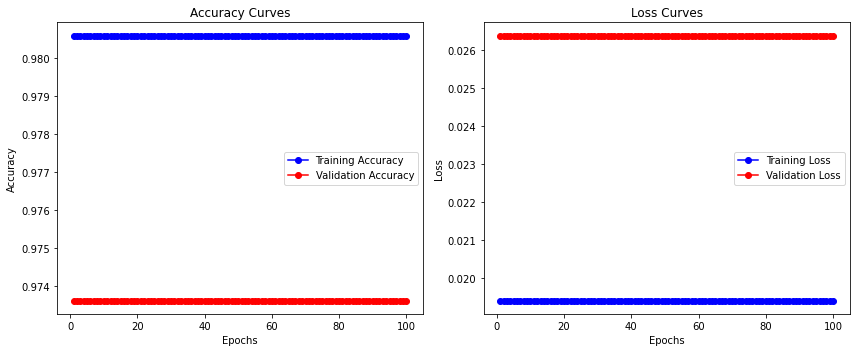

Model does not seem to be overfitting.


In [25]:
# Naive Bayes model
naive_bayes_model = MultinomialNB()

# Lists to store accuracy and loss values
train_accuracy = []
val_accuracy = []
train_loss = []
val_loss = []

# Train the model and store accuracy and loss values
for epoch in range(100):
    naive_bayes_model.fit(X_train_tfidf, y_train)
    
    # Calculate training accuracy and loss
    train_preds = naive_bayes_model.predict(X_train_tfidf)
    train_accuracy.append(accuracy_score(y_train, train_preds))
    train_loss.append(1 - naive_bayes_model.score(X_train_tfidf, y_train))
    
    # Calculate validation accuracy and loss
    val_preds = naive_bayes_model.predict(X_test_tfidf)
    val_accuracy.append(accuracy_score(y_test, val_preds))
    val_loss.append(1 - naive_bayes_model.score(X_test_tfidf, y_test))

# Evaluate Naive Bayes model
print("Naive Bayes Accuracy:", accuracy_score(y_test, naive_bayes_model.predict(X_test_tfidf)))
print("Naive Bayes Classification Report:")
print(classification_report(y_test, naive_bayes_model.predict(X_test_tfidf)))

# Plot accuracy and loss curves
epochs = range(1, len(train_accuracy) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

plt.tight_layout()
plt.show()

# Check for overfitting
if train_accuracy[-1] - val_accuracy[-1] > 0.2 or val_loss[-1] - train_loss[-1] > 0.2:
    print("Warning: Model may be overfitting.")
else:
    print("Model does not seem to be overfitting.")